# Linear Regression in TF Probability using JointDistributionCoroutineAutoBatched

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML, TFP, TF]

### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd

tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:
def lr(x, stddv_datapoints):
    num_datapoints, data_dim = x.shape
    b = yield tfd.Normal(
        loc=0.0,
        scale=2.0,
        name="b",
    )
    w = yield tfd.Normal(
        loc=tf.zeros([data_dim]), scale=2.0 * tf.ones([data_dim]), name="w"
    )

    y = yield tfd.Normal(
        loc=tf.linalg.matvec(x, w) + b, scale=stddv_datapoints, name="y"
    )

In [21]:
x = tf.linspace(-5.0, 5.0, 100)
x = tf.expand_dims(x, 1)

In [56]:
stddv_datapoints = 1

concrete_lr_model = functools.partial(lr, x=x, stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_lr_model)

In [57]:
model

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  b=[],
  w=[1],
  y=[100]
) dtype=StructTuple(
  b=float32,
  w=float32,
  y=float32
)>

In [58]:
actual_b, actual_w, y_train = model.sample()

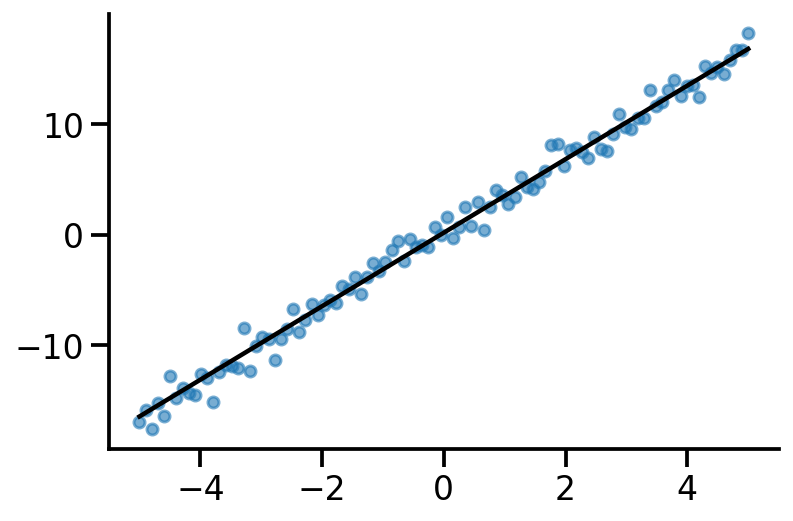

In [59]:
plt.scatter(x, y_train, s=30, alpha=0.6)
plt.plot(x, tf.linalg.matvec(x, actual_w) + actual_b, color="k")
sns.despine()

In [60]:
trace_fn = lambda traceable_quantities: {
    "loss": traceable_quantities.loss,
    "w": w,
    "b": b,
}

In [61]:
data_dim = 1
w = tf.Variable(tf.zeros_like(actual_w))

b = tf.Variable(tf.zeros_like(actual_b))

target_log_prob_fn = lambda w, b: model.log_prob((b, w, y_train))
trace = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, b),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    trace_fn=trace_fn,
    num_steps=200,
)

2022-02-05 14:52:54.004778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [62]:
w, b, actual_w, actual_b

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([3.3579512], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14496608>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.3209429], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.17017412>)

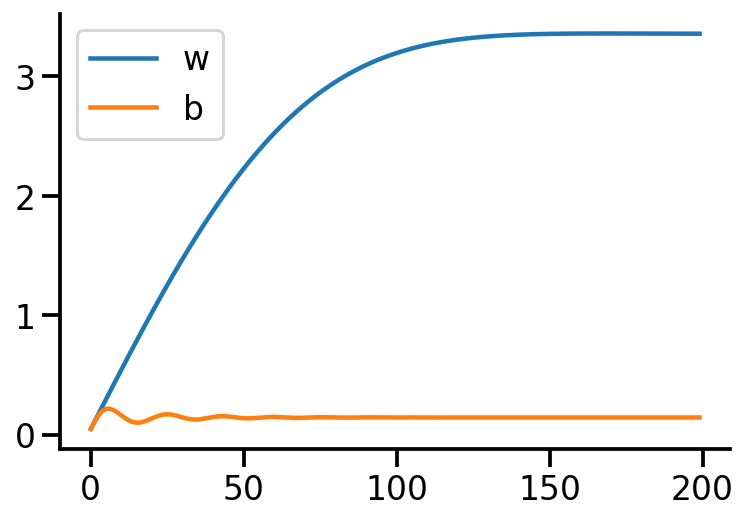

In [66]:
plt.plot(trace["w"], label="w")
plt.plot(trace["b"], label="b")
plt.legend()
sns.despine()

In [70]:
qw_mean = tf.Variable(tf.random.normal([data_dim]))
qb_mean = tf.Variable(tf.random.normal([1]))
qw_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([data_dim]), bijector=tfb.Softplus()
)
qb_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([1]), bijector=tfb.Softplus())

In [71]:
def factored_normal_variational_model():
    qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qb = yield tfd.Normal(loc=qb_mean, scale=qb_stddv, name="qb")


surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model
)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200,
)

/Users/nipun/miniforge3/lib/python3.9/site-packages/tensorflow_probability/python/internal/vectorization_util.py:87: UserWarning: Saw Tensor seed Tensor("seed:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(
/Users/nipun/miniforge3/lib/python3.9/site-packages/tensorflow_probability/python/internal/vectorization_util.py:87: UserWarning: Saw Tensor seed Tensor("seed:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which 

In [82]:
qw_mean, qw_stddv, qb_mean, qb_stddv

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([3.3589635], dtype=float32)>,
 <TransformedVariable: name=softplus, dtype=float32, shape=[1], fn="softplus", numpy=array([0.03856377], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.14226167], dtype=float32)>,
 <TransformedVariable: name=softplus, dtype=float32, shape=[1], fn="softplus", numpy=array([0.08421765], dtype=float32)>)

TODO

1. How to replace x in `lr` function from x_train to x_test?


References

- https://www.tensorflow.org/probability/examples/Probabilistic_PCA
- https://www.youtube.com/watch?v=l2f6Ic6SeqE&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=4
- https://jeffpollock9.github.io/almost-always-auto-batched/
- https://jeffpollock9.github.io/bayesian-workflow-with-tfp-and-arviz/